In [116]:
#some of blocks below are not used.
import random
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys

import os
from glob import glob
from PIL import Image
from collections import defaultdict

import zipfile

In [21]:
# Extract train and test images 

with zipfile.ZipFile("/teamspace/studios/this_studio/ProjectIII/data/faces/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/teamspace/studios/this_studio/ProjectIII/data/faces/train")

with zipfile.ZipFile("/teamspace/studios/this_studio/ProjectIII/data/faces/test.zip", 'r') as zip_ref:
    zip_ref.extractall("/teamspace/studios/this_studio/ProjectIII/data/faces/test")


In [73]:
# For reproducibility purposes
np.random.seed(42)

BATCH_SIZE=64
NUMBER_EPOCHS=5
IMG_SIZE=100

In [97]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.cpu.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()

In [76]:
#F09xx are used for validation.
val_famillies = "F09"

#An example of data:"../input/train/F00002/MID1/P0001_face1.jpg"

all_images = glob("/teamspace/studios/this_studio/ProjectIII/data/faces/train/*/*/*.jpg")


train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)#Put the link of each picture under the key word of a person such as "F0002/MID1"
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
relationships = pd.read_csv("/teamspace/studios/this_studio/ProjectIII/data/faces/train_relationships.csv")

relationships = list(zip(relationships.p1.values, relationships.p2.values))#For a List like[p1 p2], zip can return a result like [(p1[0],p2[0]),(p1[1],p2[1]),...]
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]#filter unused relationships

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(train))    
print("Total val pairs:", len(val))   


Total train pairs: 3066
Total val pairs: 296


In [24]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.relationships = relationships #choose either train or val dataset to use
        self.transform = transform
        
    def __getitem__(self,index):
        img0_info = self.relationships[index][0]#for each relationship in train_relationships.csv, the first img comes from first row, and the second is either specially choosed related person or randomly choosed non-related person
        img0_path = glob("/teamspace/studios/this_studio/ProjectIII/data/faces/train/"+img0_info+"/*.jpg")
        img0_path = random.choice(img0_path)
        
        cand_relationships = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info]#found all candidates related to person in img0
        if cand_relationships==[]:#in case no relationship is mensioned. But it is useless here because I choose the first person line by line.
            should_get_same_class = 0
        else:
            should_get_same_class = random.randint(0,1) 

        if should_get_same_class==1:#1 means related, and 0 means non-related.
            img1_info = random.choice(cand_relationships)#choose the second person from related relationships
            if img1_info[0]!=img0_info:
                img1_info=img1_info[0]
            else:
                img1_info=img1_info[1]
            img1_path = glob("/teamspace/studios/this_studio/ProjectIII/data/faces/train/"+img1_info+"/*.jpg")#randomly choose a img of this person
            img1_path = random.choice(img1_path)
        else:#0 means non-related
            randChoose = True#in case the chosen person is related to first person
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]
                img1_info = img1_path.split("/")[-3] + "/" + img1_path.split("/")[-2]
                randChoose = False
                for x in cand_relationships:#if so, randomly choose another person
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break
                    
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        
        if self.transform is not None:#I think the transform is essential if you want to use GPU, because you have to trans data to tensor first.
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , should_get_same_class #the returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
    
    def __len__(self):
        return len(self.relationships)#essential for choose the num of data in one epoch

In [77]:
folder_dataset = dset.ImageFolder(root='/teamspace/studios/this_studio/ProjectIII/data/faces/train')

trainset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=train,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=BATCH_SIZE)
valset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=val,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)

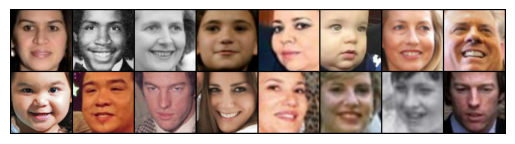

[1 0 1 0 1 1 1 0]


In [78]:
#only for visualize data in dataloader, it won't matters if you delete this block.
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [79]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #self.cnn1 = models.resnet50(pretrained=True)#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        #self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)


    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

### Training the model - net

In [80]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

best_epoch_accuracy = 0


for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")

    net.train()  # Set the network to training mode
    
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        
        
        #print(f'labels    {labels}      \n \n  img0  {img0}')
        
        
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!

        net.eval()  # Set the network to evaluation mode

        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    acc = 100 * correct_val / total_val  
    
    if epoch == 0:
        best_epoch_accuracy = acc
        print('Model Saved0')
        torch.save(net.state_dict(), '/teamspace/studios/this_studio/ProjectIII/data/faces/saved_model.pth')
    else:
        if best_epoch_accuracy < acc:
            best_epoch_accuracy = acc
            print('Model Saved1')
            torch.save(net.state_dict(), '/teamspace/studios/this_studio/ProjectIII/data/faces/saved_model.pth')

        elif best_epoch_accuracy > acc:
            pass

        else:   #  best_epoch_accuracy == acc:
            pass

    print('Accuracy of the network on the', total_val, 'val pairs in',val_famillies, ': %d %%' % (acc))
 

Epoch： 0  start.
Model Saved0
Accuracy of the network on the 296 val pairs in F09 : 57 %
Epoch： 1  start.
Model Saved1
Accuracy of the network on the 296 val pairs in F09 : 63 %
Epoch： 2  start.
Accuracy of the network on the 296 val pairs in F09 : 53 %
Epoch： 3  start.
Accuracy of the network on the 296 val pairs in F09 : 62 %
Epoch： 4  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


### Using the best model with our DataSet

In [117]:
#Later to restore:
model=SiameseNetwork().cuda()
model.load_state_dict(torch.load('/teamspace/studios/this_studio/ProjectIII/data/faces/saved_model.pth'))
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=640000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)

In [125]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
   
    def __init__(self,input_image_path,other_images_path,transform=None):
        self.transform = transform
        self.input_image_path = input_image_path
        self.other_images_path = other_images_path
       
    def __getitem__(self,index):
        img0_path = self.input_image_path
        img1_path = self.other_images_path[index]
       
        img0 = Image.open(img0_path).convert('RGB')
        img1 = Image.open(img1_path).convert('RGB')
 
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
       
        return img0, img1, img0_path, img1_path

    '''def getpath(self,index):
        img0_path = self.input_image_path
        img1_path = self.other_images_path[index]

        return img0_path, img1_path
'''
   
    def __len__(self):
        return len(other_images_paths)

In [126]:
folder_path = '/teamspace/studios/this_studio/ProjectIII/data/fashion/dresses_no_bg'
#folder_path= '/teamspace/studios/this_studio/ProjectIII/siamese_network/test'
# Create list with all the images paths
image_paths = glob(os.path.join(folder_path, "*.jpg"))
input_image_path = image_paths[0]
other_images_paths = image_paths[1:]

 
testset = testDataset(input_image_path, other_images_paths, transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=2,
                        batch_size=1)

In [144]:
predictions=[]
similarities_scores = []
similar_images_paths = []

with torch.no_grad():
    for data in testloader:
       
        img0, img1, p0 , p1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = model(img0,img1)
        #print(f'output: {outputs}')
 
        x, predicted = torch.max(outputs, 1)
      
       
        # If the images are similar, then append the similarity score
        if predicted == 1:
            # print('Imagen similar')
            similarities_scores.append(x)
            #print(p1[0])
            similar_images_paths.append(p1[0])
 
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)
 
# Sort the images by its
score_image_pairs = list(zip(similarities_scores, similar_images_paths))
sorted_pairs = sorted(score_image_pairs, key=lambda x: x[0], reverse=True)

top_n_scores, top_n_images_paths = zip(*sorted_pairs)
# print(f"Top {n} Scores:", top_n_scores)

top_n_images_paths=list(top_n_images_paths)
# print("Corresponding Images:", top_n_images_paths)

Top 3 Scores: (tensor([2.5394], device='cuda:0'), tensor([0.7735], device='cuda:0'), tensor([0.6124], device='cuda:0'), tensor([0.3971], device='cuda:0'), tensor([0.2681], device='cuda:0'), tensor([0.2606], device='cuda:0'), tensor([0.2582], device='cuda:0'), tensor([0.2580], device='cuda:0'), tensor([0.2338], device='cuda:0'), tensor([0.2305], device='cuda:0'), tensor([0.2125], device='cuda:0'), tensor([0.2058], device='cuda:0'), tensor([0.1904], device='cuda:0'), tensor([0.1719], device='cuda:0'), tensor([0.1346], device='cuda:0'), tensor([0.1333], device='cuda:0'), tensor([0.1228], device='cuda:0'), tensor([0.1209], device='cuda:0'), tensor([0.1203], device='cuda:0'), tensor([0.1163], device='cuda:0'), tensor([0.1149], device='cuda:0'), tensor([0.0996], device='cuda:0'), tensor([0.0912], device='cuda:0'), tensor([0.0823], device='cuda:0'), tensor([0.0761], device='cuda:0'), tensor([0.0748], device='cuda:0'), tensor([0.0731], device='cuda:0'), tensor([0.0600], device='cuda:0'), tenso

'\nimg0 = img0.cpu()\nimg0 = img0.detach().squeeze().permute(1,2,0)\nplt.imshow(img0) \nplt.show()\n\nfor img in top_n_images:\n    img = img.cpu()\n    img = img.detach().squeeze().permute(1,2,0)\n    plt.imshow(img) \n    plt.show()'

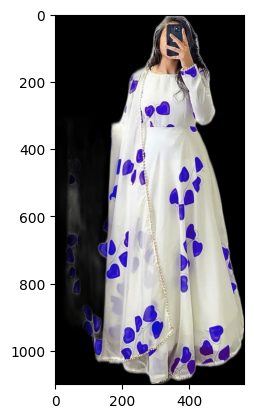

In [147]:
input_image_path = image_paths[0]
img = Image.open(input_image_path).convert('RGB')
plt.imshow(img) 
plt.show()

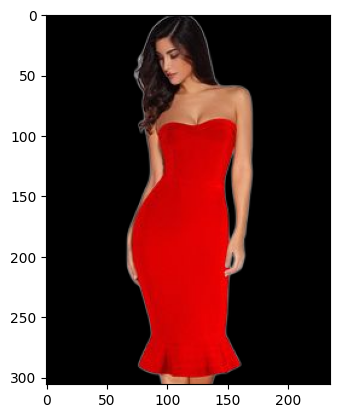

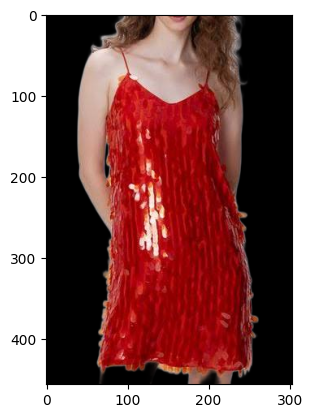

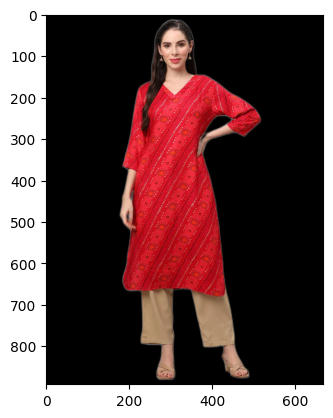

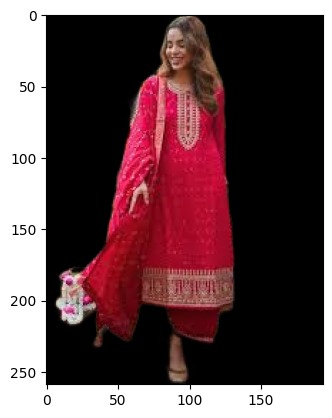

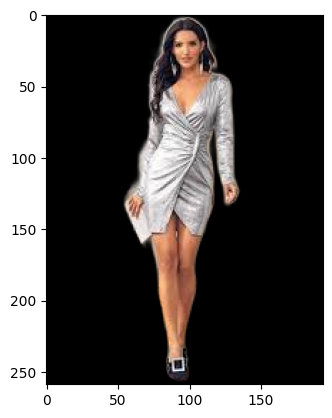

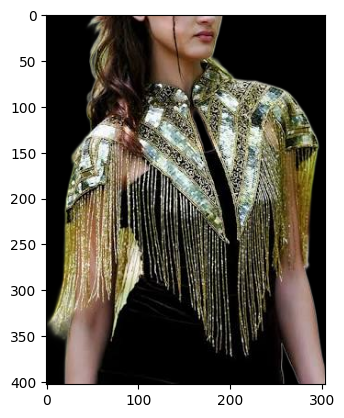

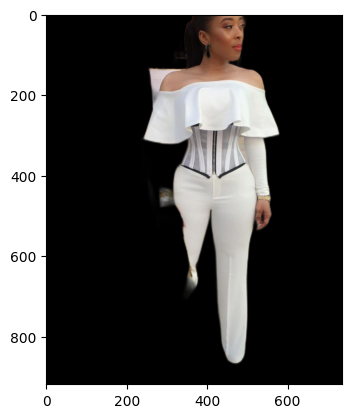

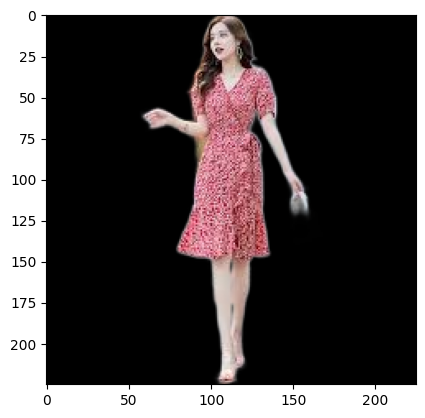

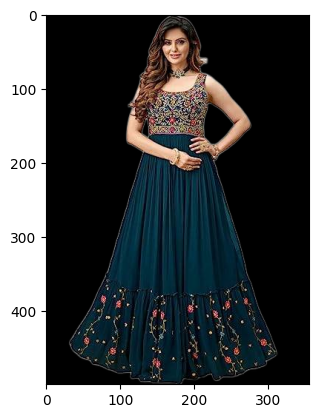

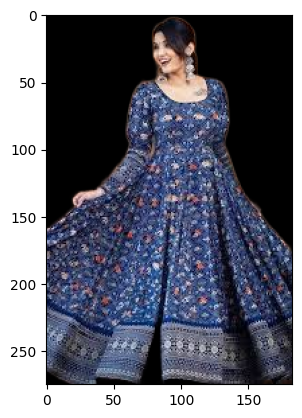

In [148]:
c = 0
for i in range(len(top_n_images_paths[:10])):
    img = Image.open(top_n_images_paths[i]).convert('RGB')
    plt.imshow(img) 
    plt.show()

In [141]:
list(top_n_images_paths)

['/teamspace/studios/this_studio/ProjectIII/women_fashion_rb/strapless red midi dress with a mermaid silhouette.jpg',
 '/teamspace/studios/this_studio/ProjectIII/women_fashion_rb/bright red, sequined dress with thin shoulder straps.jpg',
 '/teamspace/studios/this_studio/ProjectIII/women_fashion_rb/bright red kurta with an intricate patterned design.jpg']